In [1]:
%matplotlib inline
import numpy as np
from classy import Class
import matplotlib.pyplot as plt

In [2]:
z_range = np.arange(0, 1.0, 0.5) # Redshift range/grid
kmax = 0.2 # kmax
k_range = np.logspace(-3, np.log10(kmax)) # k grid
mnu_range = np.arange(0, 0.2, 0.05) # grid of neutrino masses (active neutrinos)

In [3]:
# Class / Classy parameters - see documentation for details
verbosity = 1
verbose = {
    'input_verbose': verbosity, 'background_verbose': verbosity,
    'thermodynamics_verbose': verbosity, 'perturbations_verbose': verbosity,
    'transfer_verbose': verbosity, 'primordial_verbose': verbosity,
    'spectra_verbose': verbosity, 'nonlinear_verbose': verbosity,
    'lensing_verbose': verbosity, 'output_verbose': verbosity
}
# Gahhhh so many parameters 
scenario = {
    'h': 0.67556,'T_cmb': 2.7255,
    'omega_b': 0.022032,'N_ur': 2.03351,'m_ncdm': 0.04,
    'ncdm_psd_parameters': '0.3 ,0.5, 0.05',
    'N_ncdm': 1,'T_ncdm': 0.715985,'omega_cdm': 0.12038,
    'Omega_fld': 0,'Omega_scf': 0,'Omega_k': 0,
    'YHe': 'BBN','z_reio': 11.357,'lensing': 'yes',
    'reio_parametrization': 'reio_camb',
    'recombination': 'RECFAST','k_pivot': 0.05,
    'A_s': 2.215e-9,'n_s': 0.9619,
    'alpha_s': 0., 'output': 'mPk', 'P_k_max_1/Mpc': kmax, 
    'lensing': 'no', 'non linear': 'halofit',
    'z_pk': ', '.join([str(z) for z in z_range])
    }

In [4]:
# create cosmology object and compute P(k) on the redshift/k grid defined above.
# Important: omega_cdm is adjusted to keep the other main parameters fixed (omega_M+K+Lambda)
# It is not essential but it makes the effect of neutrinos easier to visualize
# and more meaningful since these parameters will be constrained around these values anyway.
cosmo = Class()
pk = np.zeros((k_range.size, z_range.size, mnu_range.size))
for imnu, mnu in enumerate(mnu_range):
    scenario.update({'m_ncdm': mnu, 'omega_cdm': 0.12038 - mnu / 94.07})
    cosmo.set(dict(verbose.items()+scenario.items()))
    cosmo.compute()    
    for iz, z in enumerate(z_range):
        for ik, k in enumerate(k_range):
            pk[ik,iz,imnu] = cosmo.pk(k, z)

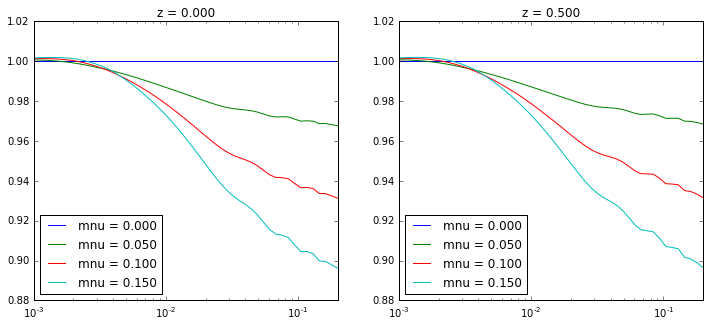

In [13]:
# plot the relative effects on P(k)
fig, axs = plt.subplots(1,z_range.size, figsize=(12,5))
axs = axs.ravel()
for iz, z in enumerate(z_range):
    labs = []
    handles = []
    for imnu, mnu in enumerate(mnu_range):
        hh, = axs[iz].plot(k_range, pk[:,iz,imnu]/pk[:,iz,0])
        handles.append(hh)
        labs.append('mnu = %.3f' % mnu)
    axs[iz].legend(handles, labs, loc='lower left')
    axs[iz].set_xscale('log')
    axs[iz].set_title('z = %.3f' % z)
    axs[iz].set_xlim(k_range.min(), k_range.max())
fig.show()

In [14]:
# Now let's look at the effects on angular power spectra (as in photometric surveys)
# Need to update parameter structure with a lot of extra information.
l_max_lss = 500
binsize = 0.2 # photometric redshift bin size
zbins =  np.arange(0.2, 0.8, binsize) # grid of redshift bins
nbwin = zbins.size - 1
scenario = {
    'h': 0.67556,'T_cmb': 2.7255,
    'omega_b': 0.022032,'N_ur': 2.03351,'m_ncdm': 0.04,
    'ncdm_psd_parameters': '0.3 ,0.5, 0.05',
    'N_ncdm': 1,'T_ncdm': 0.715985,'omega_cdm': 0.12038,
    'Omega_fld': 0,'Omega_scf': 0,'Omega_k': 0,
    'YHe': 'BBN','z_reio': 11.357,'lensing': 'yes',
    'reio_parametrization': 'reio_camb',
    'recombination': 'RECFAST','k_pivot': 0.05,
    'A_s': 2.215e-9,'n_s': 0.9619,
    'output': 'tCl,lCl,nCl', 'lensing': 'no',
    'l_max_lss': l_max_lss, 'non linear': 'halofit',
    'number count contributions' : 'density, rsd, lensing, gr', # all these parameters are tricky! 
    'selection': 'gaussian', 'non_diagonal': nbwin-1,          #  see documentation for details...
    'selection_mean': ', '.join([str(z+binsize/2.0) for z in zbins[:-1]]), 
    'selection_width': binsize
}
print scenario

{'selection': 'gaussian', 'number count contributions': 'density, rsd, lensing, gr', 'N_ur': 2.03351, 'omega_cdm': 0.12038, 'z_reio': 11.357, 'lensing': 'no', 'non linear': 'halofit', 'reio_parametrization': 'reio_camb', 'ncdm_psd_parameters': '0.3 ,0.5, 0.05', 'Omega_scf': 0, 'selection_width': 0.2, 'm_ncdm': 0.04, 'YHe': 'BBN', 'non_diagonal': 2, 'N_ncdm': 1, 'T_cmb': 2.7255, 'selection_mean': '0.3, 0.5, 0.7', 'k_pivot': 0.05, 'l_max_lss': 500, 'output': 'tCl,lCl,nCl', 'omega_b': 0.022032, 'n_s': 0.9619, 'A_s': 2.215e-09, 'recombination': 'RECFAST', 'Omega_fld': 0, 'Omega_k': 0, 'h': 0.67556, 'T_ncdm': 0.715985}


In [15]:
# compute angular power spectra with these new parameters
cosmo = Class()
cls = np.zeros((l_max_lss+1, nbwin*(nbwin+1)/2, mnu_range.size))
for imnu, mnu in enumerate(mnu_range):
    scenario.update({'m_ncdm': mnu, 'omega_cdm': 0.12038 - mnu / 94.07})
    cosmo.set(dict(verbose.items()+scenario.items()))
    cosmo.compute()    
    cl = cosmo.density_cl(l_max_lss)
    ind = 0
    for i in range(nbwin):
        for j in range(nbwin):
            if j >= i:
                cls[:,ind,imnu] = cl['dd'][ind]
                ind += 1

/Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide


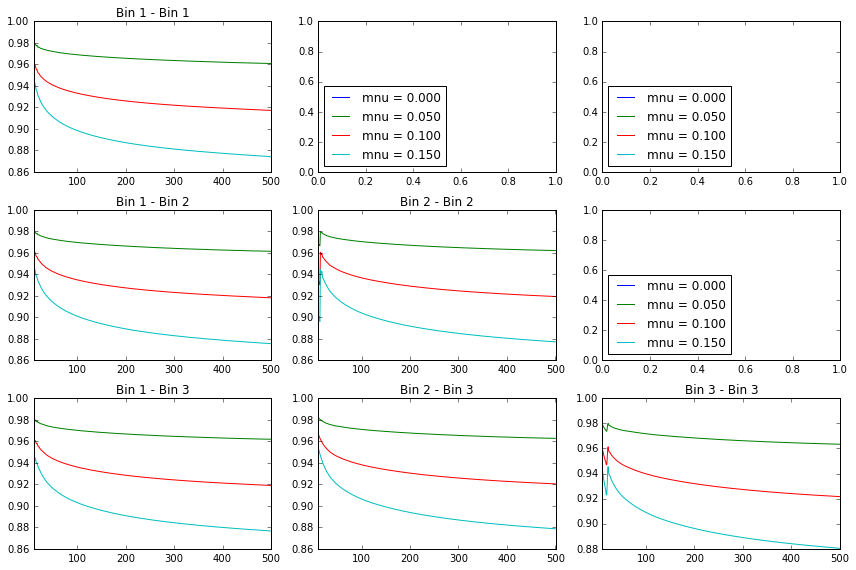

In [16]:
# now plot relative effect on angular power spectra
fig, axs = plt.subplots(nbwin,nbwin, figsize=(12,8))
axs = axs.ravel()
ell_range = np.arange(l_max_lss+1)
ind = 0
for i in range(nbwin):
    for j in range(nbwin):
        if j >= i:
            labs = []
            handles = []
            for imnu, mnu in enumerate(mnu_range):
                hh, = axs[j*nbwin+i].plot(ell_range, cls[:,ind,imnu]/cls[:,ind,0])
                handles.append(hh)
                labs.append('mnu = %.3f' % mnu)
            if j > i:
                axs[i*nbwin+j].legend(handles, labs, loc='lower left')
            axs[j*nbwin+i].set_title('Bin '+str(i+1)+' - Bin '+str(j+1))
            axs[j*nbwin+i].set_xlim([10,l_max_lss+1])
            ind += 1
fig.tight_layout()
fig.show()